# Optimization

In this notebook, we explore how the scale of gradient of loss with respect to parameters changes with layer in a feed-forward neural network. It is found that the scale varies greatly between different layers, indicating that a proper optimization algorithm shall employ different learning rates for different layers.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

%matplotlib inline

Load and process MNIST dataset.

In [2]:
(ds_train,), ds_info = tfds.load(
    'mnist',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Define a feed-forward neural network with single hidden layer. This model is simple enough for a deeper analysis.

Explicitly, it is

$$ f^{\alpha}(x) := U^{\alpha}_{\beta} \sigma \left( W^{\beta}_{\gamma} x^{\gamma} + b^{\beta} \right) + c^{\alpha}. $$

In [3]:
class FeedForwardNetwork(tf.keras.models.Model):

    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.flatten_layer = tf.keras.layers.Flatten(input_shape=(28, 28))
        self.hidden_layer = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.output_layer = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

Now, we implement an optimizer for gradient descent algorithm. It assigns different learning rates different parameters. The basic idea is the same as RMSProp algorithm, but not element-wise, but layer-wise. It is found that this optimizer performs as good as RMSProp, but need much less memory occupition.

In fact, we should use raw gradient descent algorithm for optimization, but it is too slow.

In [4]:
class Optimizer(tf.Module):
    """Layer-wise self-adaptive learning rate."""

    def __init__(self,
                 learning_rate: float = 1e-3,
                 rms: float = 0.999,
                 eps: float = 1e-7):
        self.learning_rate = learning_rate
        self.rms = rms
        self.eps = eps

        if self.rms:
            self.rms_vars = []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                if self.rms:
                    self.rms_vars.append(tf.Variable(1, dtype='float32'))
            self.built = True
        for i, (grad, var) in enumerate(zip(grads, vars)):
            new_grad = grad
            if self.rms:
                self.rms_vars[i] = self.rms*self.rms_vars[i] + (1-self.rms)*tf.reduce_mean(tf.square(grad))
                new_grad /= tf.sqrt(self.rms_vars[i]) + self.eps
            var.assign_sub(self.learning_rate * new_grad)

As a comparison, we also implement RMSProp algorithm.

In [5]:
class RMSProp(tf.Module):

    def __init__(self,
                 learning_rate: float = 1e-3,
                 rms: float = 0.9,
                 eps: float = 1e-7):
        self.learning_rate = learning_rate
        self.rms = rms
        self.eps = eps

        self.rms_vars = []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                self.rms_vars.append(tf.Variable(tf.zeros(shape=var.shape)))
            self.built = True
        for i, (grad, var) in enumerate(zip(grads, vars)):
            self.rms_vars[i] = self.rms*self.rms_vars[i] + (1-self.rms)*tf.square(grad)
            new_grad = grad / tf.sqrt(self.rms_vars[i]) + self.eps
            var.assign_sub(self.learning_rate * new_grad)

Then define loss and functions for training.

In [6]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def get_loss_and_grads(model, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    return loss_batch, grads


def train_step(model, optimizer, x_batch, y_batch):
    loss_batch, grads = get_loss_and_grads(model, x_batch, y_batch)
    optimizer.apply_gradients(grads, model.variables)
    return loss_batch

We wonder how the $\partial L / \partial W$ and $\partial L / \partial U$ vary with training.

In [7]:
def loss_weight_grad_histogram(model, x_batch, y_batch):
    _, grads = get_loss_and_grads(model, x_batch, y_batch)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].hist(grads[0].numpy().reshape([-1]),
                bins=50, density=True, label='$\partial L / \partial W$')
    axs[0].legend()
    axs[0].tick_params(rotation=45)

    axs[1].hist(grads[2].numpy().reshape([-1]),
                bins=50, density=True, label='$\partial L / \partial U$')
    axs[1].legend()
    axs[1].tick_params(rotation=45)
    return fig

Let use build a model.

In [9]:
model = FeedForwardNetwork(256)

# Build the model
ds_iter = ds_train.as_numpy_iterator()
x_batch, y_batch = next(ds_iter)
_ = model(x_batch)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


epoch = 0, loss = 0.22490496933460236
epoch = 1, loss = 0.10721168667078018
epoch = 2, loss = 0.1534942090511322
epoch = 3, loss = 0.18187950551509857
epoch = 4, loss = 0.05543980374932289
Final loss = 0.057188164442777634


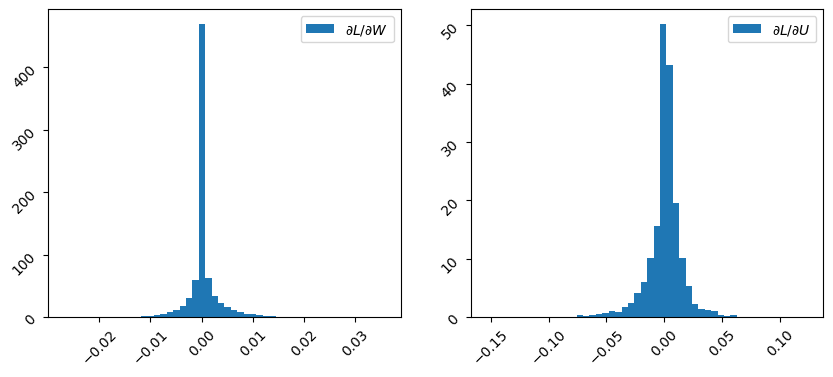

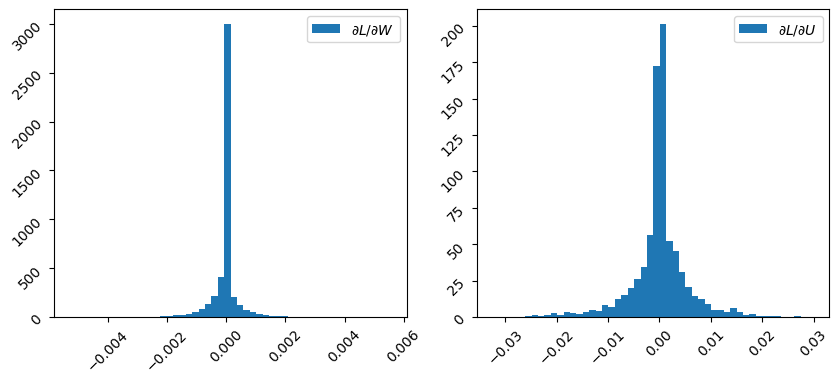

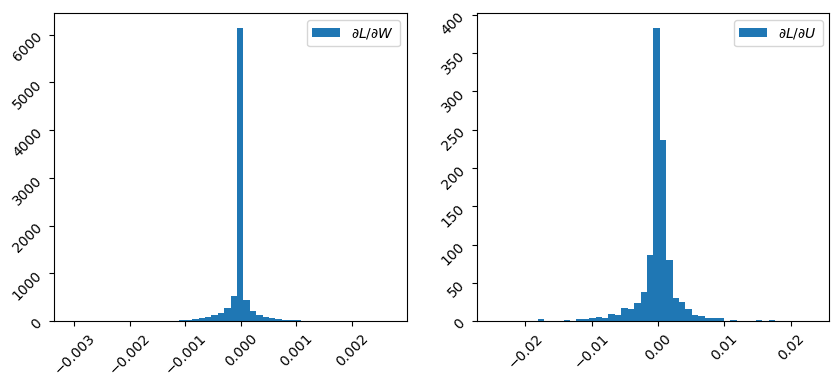

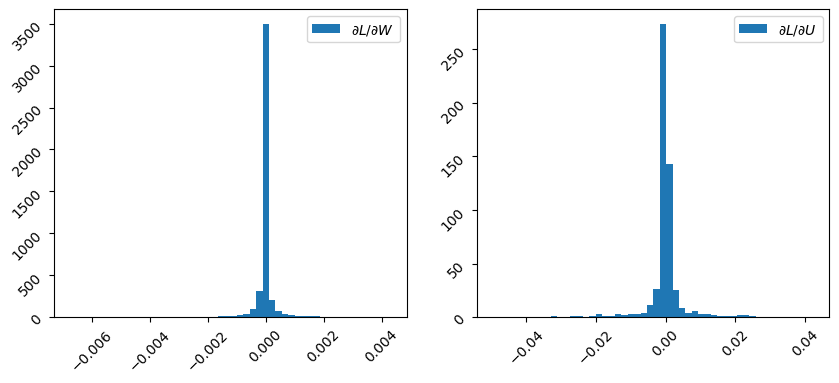

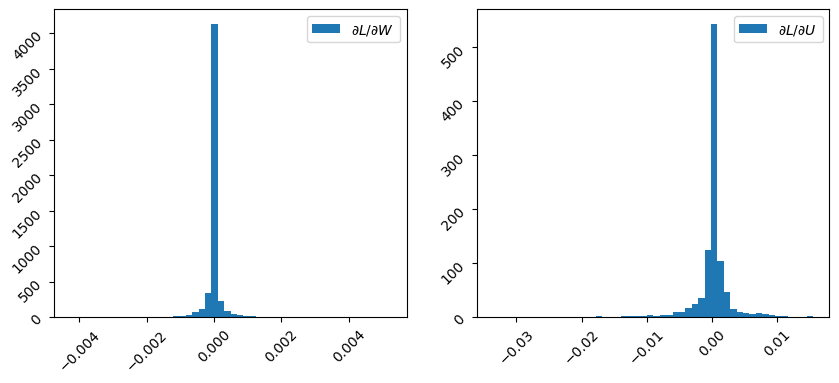

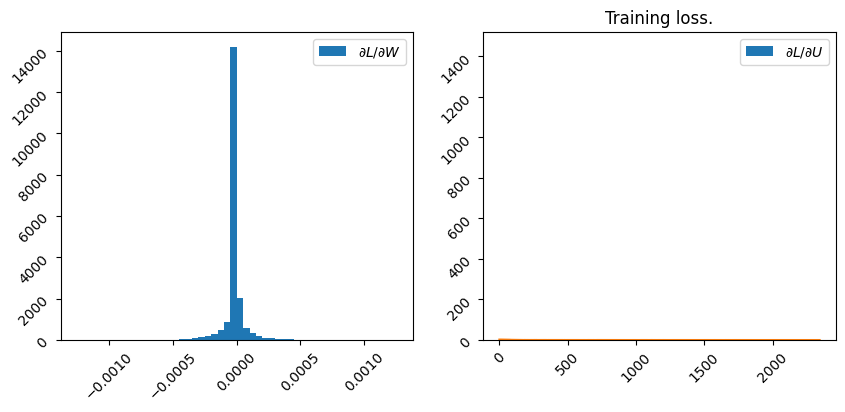

In [10]:
optimizer = Optimizer(rms=0.9)
# optimizer = RMSProp(rms=0.9)  # as a comparison.

# Initializations.
loss_values = []
hist_figs = [loss_weight_grad_histogram(model, x_batch, y_batch)]
init_vars = [var.numpy() for var in model.variables]

# Training process.
for epoch in range(5):
    ds_iter = ds_train.as_numpy_iterator()
    while True:
        try:
            x_batch, y_batch = next(ds_iter)
        except StopIteration:
            break
        loss_batch = train_step(model, optimizer, x_batch, y_batch)
        loss_values.append(loss_batch.numpy())
    hist_figs.append(loss_weight_grad_histogram(model, x_batch, y_batch))
    print(f'epoch = {epoch}, loss = {loss_batch.numpy()}')

print(f'Final loss = {np.mean(loss_values[-100:])}')

plt.plot(loss_values)
plt.title('Training loss.')
plt.show()

From the histograms plotted in different epochs, we find that $\| \partial L / \partial U \| \gg \| \partial L / \partial W \|$. But the total difference between the initial and final (after training) values of $U$ and that of $W$ share the same order!

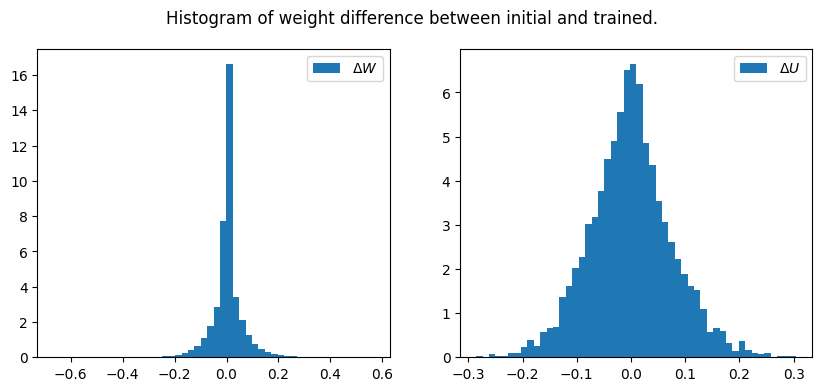

In [34]:
post_vars = [var.numpy() for var in model.variables]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist((init_vars[0] - post_vars[0]).reshape([-1]),
            bins=50, density=True, label='$\Delta W$')
axs[0].legend()

axs[1].hist((init_vars[2] - post_vars[2]).reshape([-1]),
            bins=50, density=True, label='$\Delta U$')
axs[1].legend()

fig.suptitle('Histogram of weight difference between initial and trained.')
plt.show()

This means